In [2]:
import pandas as pd
from mxnet import gluon, autograd, init, nd
from mxnet.gluon import nn
import random
import matplotlib.pyplot as plt

In [3]:
dfraw = pd.read_csv('../data/PAQI_opendata_till_2019.csv')
df = dfraw.drop_duplicates()

In [4]:
dfc.columns

Index(['SerialNumber', 'City', 'Name', 'FirstOnline', 'Datetime', 'PM2.5',
       'USAQI', 'CO2', 'Temperature', 'RelativeHumidity', 'Outdoor PM2.5',
       'OutdoorUSAQI', 'weekday', 'weekdayName', 'hour', 'month', 'year',
       'dayofmonth', 'tmpc', 'relh', 'drct', 'sped', 'vsby'],
      dtype='object')

C:\Users\Ulhaq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,aishamanzil,Defence Housing Authority,northkarachi,landhi,Korangi,Korangi (J-Area),saddar,Hyderi Market,bahadurabad,orangi town,d.h.a phase 5,karachi - industrial,shershah,Liaquatabad,mt khan road,"Civic Center, Korangi"
aishamanzil,1.000000,0.321012,0.358986,0.576200,-0.373581,0.509906,0.443265,0.433769,0.351870,0.029272,-0.103184,0.303399,0.489828,0.373261,0.407947,0.441840
Defence Housing Authority,0.321012,1.000000,0.459990,0.467358,0.720594,0.720149,0.760234,0.732152,0.731717,0.064048,0.218008,0.653782,0.570863,0.685686,0.493193,0.502704
northkarachi,0.358986,0.459990,1.000000,0.543692,0.517869,0.474289,0.458544,0.459384,0.354027,0.230914,0.104480,0.480823,0.412806,0.335033,0.371864,0.448723
landhi,0.576200,0.467358,0.543692,1.000000,0.094604,0.778462,0.378191,0.717902,0.341757,-0.031661,-0.080507,0.324181,0.429151,0.308482,0.572229,0.243385
Korangi,-0.373581,0.720594,0.517869,0.094604,1.000000,0.559713,0.496840,0.701253,0.324996,-0.053644,0.406531,0.804691,0.517987,0.492854,0.138760,0.230500
Korangi (J-Area),0.509906,0.720149,0.474289,0.778462,0.559713,1.000000,0.628842,0.719371,0.755296,0.116325,0.134780,0.536837,0.474290,0.626626,0.698396,0.782744
saddar,0.443265,0.760234,0.458544,0.378191,0.496840,0.628842,1.000000,0.651142,0.635012,0.021094,0.025221,0.455777,0.582474,0.594001,0.479294,0.643451
Hyderi Market,0.433769,0.732152,0.459384,0.717902,0.701253,0.719371,0.651142,1.000000,0.643973,0.129881,0.095483,0.594163,0.572674,0.697461,0.582466,0.506186
bahadurabad,0.351870,0.731717,0.354027,0.341757,0.324996,0.755296,0.635012,0.643973,1.000000,0.004264,0.251717,0.530323,0.321740,0.772401,0.515246,0.506449
orangi town,0.029272,0.064048,0.230914,-0.031661,-0.053644,0.116325,0.021094,0.129881,0.004264,1.000000,-0.146432,-0.233973,0.090841,0.050296,0.029664,0.450657


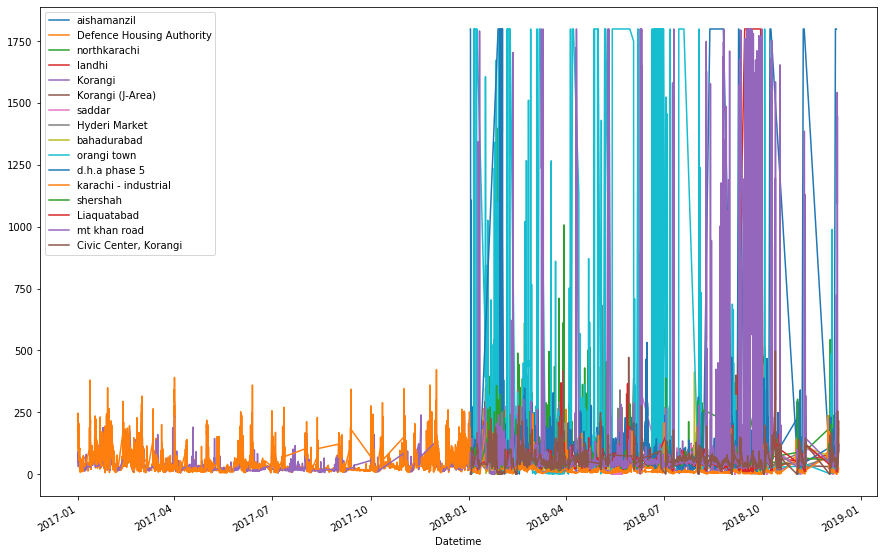

In [10]:
df_karachi = dfc[dfc.City == "Karachi"]
df_karachi_2018 = df_karachi[df_karachi.year.isin([2017, 2018])]
df_karachi_2018['Datetime'] = pd.to_datetime(df_karachi_2018.Datetime)
df_karachi_2018 = df_karachi_2018.sort_values(["Datetime"], ascending = False)
df_new = df_karachi_2018.groupby("SerialNumber")
#fig, ax = plt.subplots()
ax = plt.gca()
ax.figure.set_size_inches((15,10))

lis  = []
names = []
for i, k in df_new:
#    if k.Name.iloc[0] not in ('mt khan road', 'aishamanzil', 'orangi town', 'd.h.a phase 5'):
        k.plot('Datetime', 'PM2.5', label = k.Name.iloc[0], ax = ax)
        lis.append(k[['PM2.5', 'Datetime']].set_index('Datetime'))
        names.append(k['Name'].iloc[0])
#plt.show()

lis[0].head()
lis = pd.concat(lis, axis = 1)
lis.columns = names
lis.corr('spearman')
#drop_columns = ['City', 'Name', 'FirstOnline', 'Outdoor PM2.5', 'OutdoorUSAQI', 'weekdayName']
#df = dfc.drop(drop_columns, axis = 1)


In [6]:
of_interest = ["Defence Housing Authority","Korangi,saddar","bahadurabad","karachi - industrial","Liaquatabad"]

In [8]:
df_new.isna().mean() * 100

AttributeError: Cannot access callable attribute 'isna' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [ ]:
df= df.dropna()
len(df)

In [ ]:
df['Datetime'] = pd.to_datetime(df.Datetime)

In [ ]:
dfs = df.sort_values(['SerialNumber', 'Datetime'])
dfs = dfs.reset_index(drop = True)

In [ ]:
batch_size = 16

In [ ]:
def make_dataset_many_to_one(dataframe, time_steps):
    rows = dataframe.shape[0] - time_steps
    cols = dataframe.shape[1]
    dfnew = nd.zeros(shape = (rows, cols * time_steps))
    for i in range(0, time_steps):
        dfnew[:, i * cols : (i + 1 ) * cols] = dataframe.iloc[i: i + rows,:]
    ynew = nd.zeros(shape = (rows, 1))
    ynew[:,0] = dataframe['PM2.5'].iloc[time_steps:]
    return dfnew, ynew

In [ ]:
def myPartSerial(i, time_steps):
    dfslice = dfs[dfs.SerialNumber == i]
    lis = []
        
    dfdiff = dfslice.Datetime.diff()
    dfdiff.iloc[0] = dfdiff.iloc[1]
    dfdiff2 = dfdiff != pd.Timedelta('1 hour')
    dfdiff3 = dfdiff2.cumsum()    
    
    for j,k in dfslice.groupby(dfdiff3):
        if len(k) > time_steps:
            d = k.iloc[:]
            drop_columns2 = ['SerialNumber', 'Datetime', 'year', 'relh', 'tmpc']
            d = d.drop(drop_columns2, axis = 1)
            lis.append( d )
    
    newlis = []
    newlabels = []
    for i in lis:
        a, b = make_dataset_many_to_one(i, time_steps)
        assert a.shape[0] == b.shape[0]
        newlis.append(a)
        newlabels.append(b)
    
        
#    if lis:
#        lis = pd.concat(lis)
#    else:
#        lis = dfslice.iloc[0:0]
    
    newlis = nd.array(newlis)
    print(newlist.shape)
    
    
    return newlis, newlabels

In [ ]:
dfs.head(5)

In [ ]:
#lis = []
for i in dfs.SerialNumber.unique()[:1]:
    li = myPartSerial(i, 4)
#    lis.append(li)

#lis = pd.concat(lis)
#print(len(lis))

In [ ]:
print(dfs.SerialNumber.unique())

In [ ]:
net = nn.Sequential()
net.add(gluon.rnn.LSTM(100, num_layers = 3),
       nn.Dense(1)
       )

net